<a href="https://colab.research.google.com/github/djbiega/Convex-Optimization/blob/Formatting-Updates/AAE561_HW2_Biega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Derek Biega AAE561 Homework 2

# Problem statement: 
$$\min_{\mathbb x \in B(x_c,r)}\|Ax-b\|^2 \text{ where } A\in\mathbb{R}^{m\times n}, b\in\mathbb{R}^{m}, x_c\in\mathbb{R}^{n}, \text{and }r>0$$ 
$$\text{Choose any m, n, A, b, $x_c$ and r. Use gradient mapping to solve.}$$

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from itertools import product, combinations
from numpy.linalg import inv
import scipy.optimize as opt
import scipy
from scipy.optimize import minimize
import cvxpy as cp

### Defining all constants
$$\text{let }m=n=3, \text{and }x_c=\begin{bmatrix}0\\0\\0\end{bmatrix},\text{ and } r=1 $$
<par>Note that the A,b matrices are populated with random integers between 0-9 and will re-populate with new random integers every time this cell is run. Because of this, the optimal solution will always change. Note also that adjusting the range of parameters which can be populated in the A and b can also greatly vary results.</par>

In [2]:
m = 3
n = 3
global A,b
A = np.random.randint(10, size=(m,n))
b=np.random.randint(10,size=(m,1))
x_c=np.zeros((n,1))
print("A = \n{}".format(A)) 
print("b = \n{}".format(b))

A = 
[[0 3 0]
 [1 2 7]
 [3 1 2]]
b = 
[[0]
 [9]
 [8]]


### Functions
$$f(x)=\|Ax-b\|^2$$
$$f'(x)=\begin{bmatrix}2A_{11}(A_{11}x_1+A_{12}x_2+A_{13}x_3-b_1)+2A_{21}(A_{21}x_1+A_{22}x_2+A_{23}x_3-b_2)+2A_{31}(A_{31}x_1+A_{32}x_2+A_{33}x_3-b_3)\\2A_{12}(A_{11}x_1+A_{12}x_2+A_{13}x_3-b_1)+2A_{22}(A_{21}x_1+A_{22}x_2+A_{23}x_3-b_2)+2A_{32}(A_{31}x_1+A_{32}x_2+A_{33}x_3-b_3)\\2A_{13}(A_{11}x_1+A_{12}x_2+A_{13}x_3-b_1)+2A_{23}(A_{21}x_1+A_{22}x_2+A_{23}x_3-b_2)+2A_{33}(A_{31}x_1+A_{32}x_2+A_{33}x_3-b_3)\end{bmatrix}$$
$$x_Q(\bar{x};\gamma) = [f(\bar{x})+\langle f'(\bar{x}), x-\bar{x} \rangle +\frac{\gamma}{2}\|x-\bar{x}\|]^2$$
$$g_Q(x;\gamma) = \gamma(\bar{x}-x_Q(\bar{x};\gamma))$$


In [0]:
mag = lambda x: np.linalg.norm(x)
f = lambda x: mag(A@x-b)**2
dfx1 = lambda x: 2*A[0,0]*(A[0,0]*x[0]+A[0,1]*x[1]*A[0,2]*x[2]-b[0]) + 2*A[1,0]*(A[1,0]*x[0]+A[1,1]*x[1]*A[1,2]*x[2]-b[1]) + \
                     2*A[2,0]*(A[2,0]*x[0]+A[2,1]*x[1]*A[2,2]*x[2]-b[2])
dfx2 = lambda x: 2*A[0,1]*(A[0,0]*x[0]+A[0,1]*x[1]*A[0,2]*x[2]-b[0]) + 2*A[1,1]*(A[1,0]*x[0]+A[1,1]*x[1]*A[1,2]*x[2]-b[1]) + \
                     2*A[2,1]*(A[2,0]*x[0]+A[2,1]*x[1]*A[2,2]*x[2]-b[2])
dfx3 = lambda x: 2*A[0,2]*(A[0,0]*x[0]+A[0,1]*x[1]*A[0,2]*x[2]-b[0]) + 2*A[1,2]*(A[1,0]*x[0]+A[1,1]*x[1]*A[1,2]*x[2]-b[1]) + \
                     2*A[2,2]*(A[2,0]*x[0]+A[2,1]*x[1]*A[2,2]*x[2]-b[2])
dfx = lambda x: np.array([dfx1(x), dfx2(x), dfx3(x)])
x_Q = lambda xbar,gamma: (gamma*xbar-dfx(xbar))/(2*gamma)
g_Q = lambda xbar,gamma: gamma*(xbar-x_Q(xbar,gamma))

### Defining step sizes
I noticed that the step size resulting from the Lipschitz constant was often too large, though this depends on the integers populated in matrix A and b. To account for this, I plotted results for a step size from the Lipschitz constant as well as using a constant step size which will produce a consistent amount of iterations in the gradient mapping algorithm

In [4]:
# Calculate Lipschitz constant, step size, and magnitude
L = mag(dfx(x_c))
magnitude=mag(dfx(x_c))

# Lipschitz step size
h1 = 1/L
print("Lipschitz step size: " + str(h1))

# Comparison step size
h2 = 0.0001
print("Comparison step size: " + str(h2))

Lipschitz step size: 0.005588074808460539
Comparison step size: 0.0001


<par> Note that here I iterated the gradient mapping algorithm until the distance of the point from the origin was greater than 1. This ensures that the points are constrained within the ball of radius 1. </par>

In [0]:
def grad_mapping(x_c,h):
  
  count = 0
  xvalues = []
  yvalues=[]
  zvalues=[]
  radius=[]
  radius.append(np.zeros((1,1)))
  radtemp=0
  
  while radtemp < 1:
    
    xvalues.append(x_c[0])
    yvalues.append(x_c[1])
    zvalues.append(x_c[2])
    
    if x_c[0]!=0 and x_c[1]!=0 and x_c[2]!=0:
      radtemp = np.sqrt(x_c[0]**2+x_c[1]**2+x_c[2]**2)  
      radius.append(np.sqrt(x_c[0]**2+x_c[1]**2+x_c[2]**2))
      
    xQ = x_Q(x_c,h)
    gQ = g_Q(x_c,h)
    temp = x_c-h*gQ
    x_c = temp
    count+=1
    
  return xvalues[:-2],yvalues[:-2],zvalues[:-2],radius[:-2],count-1

In [6]:
xvalues1,yvalues1,zvalues1,radius1,iterations1 = grad_mapping(x_c,h1)
print('Lipschitz Step Size Constrained Optimal Solution: ')
print('x,y,z coordinates: \n(' + str(xvalues1[-1]) + ', ' + str(yvalues1[-1]) + ', ' + str(zvalues1[-1]) + ')')
print('Radius: \n' + str(radius1[-1]))
print('Total iterations: \n' + str(iterations1))

Lipschitz Step Size Constrained Optimal Solution: 
x,y,z coordinates: 
([0.18440647], [0.14528995], [0.44145791])
Radius: 
[0.5]
Total iterations: 
3


In [7]:
xvalues2,yvalues2,zvalues2,radius2,iterations2 = grad_mapping(x_c,h2)
print('Comparison Step Size Constrained Optimal Solution: ')
print('x,y,z coordinates: \n(' + str(xvalues2[-1]) + ', ' + str(yvalues2[-1]) + ', ' + str(zvalues2[-1]) + ')')
print('Total iterations: \n' + str(iterations2))

Comparison Step Size Constrained Optimal Solution: 
x,y,z coordinates: 
([0.37904204], [0.28878994], [0.86997655])
Total iterations: 
132


### Visual output of the Lipschitz Step Size Constrained Optimal Solution:

Constrained Optimal x,y,z coordinates: 
([0.18440647], [0.14528995],[0.44145791])
Radius: 
[0.5]


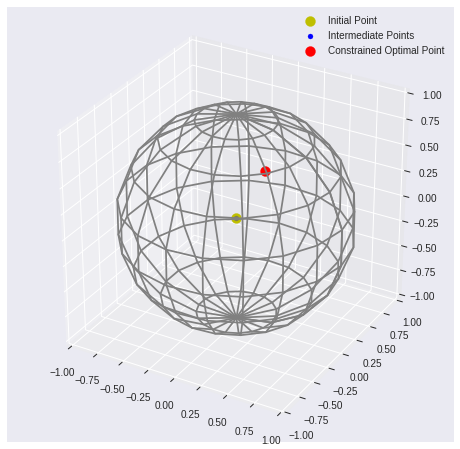

In [8]:
xfinal = xvalues1[-1]
yfinal = yvalues1[-1]
zfinal = zvalues1[-1]
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
u,v=np.mgrid[0:2*np.pi:20j,0:np.pi:10j]
ball1=np.cos(u)*np.sin(v)
ball2=np.sin(u)*np.sin(v)
ball3=np.cos(v)
ax.plot_wireframe(ball1,ball2,ball3,color="grey")
ax.scatter([0],[0],[0], color="y",s=100,label="Initial Point")
ax.scatter([xvalues1],[yvalues1],[zvalues1],color="b",s=25,label="Intermediate Points")
ax.scatter([xfinal],[yfinal],[zfinal], color="r",s=100,label="Constrained Optimal Point")
ax.legend()
print('Constrained Optimal x,y,z coordinates: \n(' + str(xfinal) + ', ' + str(yfinal) + ',' + str(zfinal) + ')')
print('Radius: \n'+ str(radius1[-1]))

### Visual output of the Comparison Step Size Constrained Optimal Solution:

Constrained Optimal x,y,z coordinates: 
([0.37904204], [0.28878994],[0.86997655])
Radius: 
[0.99193332]


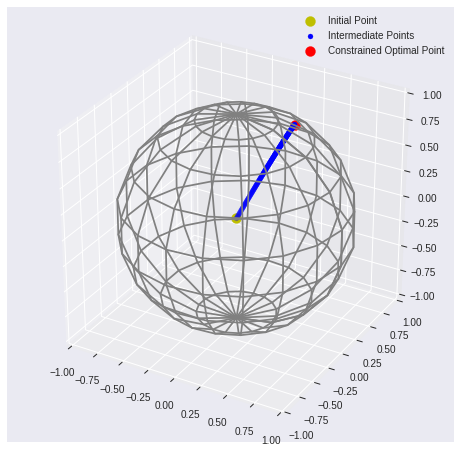

In [9]:
xfinal = xvalues2[-1]
yfinal = yvalues2[-1]
zfinal = zvalues2[-1]
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
u,v=np.mgrid[0:2*np.pi:20j,0:np.pi:10j]
ball1=np.cos(u)*np.sin(v)
ball2=np.sin(u)*np.sin(v)
ball3=np.cos(v)
ax.plot_wireframe(ball1,ball2,ball3,color="grey")
ax.scatter([0],[0],[0], color="y",s=100,label="Initial Point")
ax.scatter([xvalues2],[yvalues2],[zvalues2],color="b",s=25,label="Intermediate Points")
ax.scatter([xfinal],[yfinal],[zfinal], color="r",s=100,label="Constrained Optimal Point")
ax.legend()
print('Constrained Optimal x,y,z coordinates: \n(' + str(xfinal) + ', ' + str(yfinal) + ',' + str(zfinal) + ')')
print('Radius: \n'+ str(radius2[-1]))